In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np # for data manipulation
import tensorflow as tf
import seaborn as sns

# Sklearn
from sklearn.linear_model import LinearRegression # for building a linear regression model
from sklearn.svm import SVR, SVC # for building SVR model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder


# Visualizations
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
import plotly
import plotly.graph_objs as go

from tabulate import tabulate
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

**VISUALIZACIÓN DE DATOS**

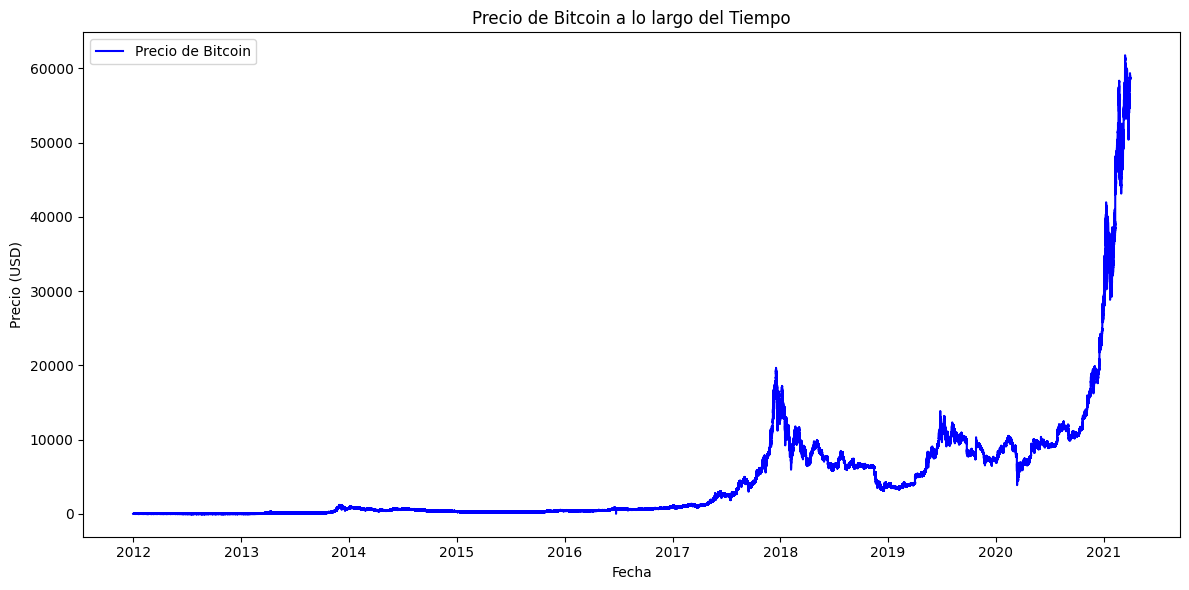

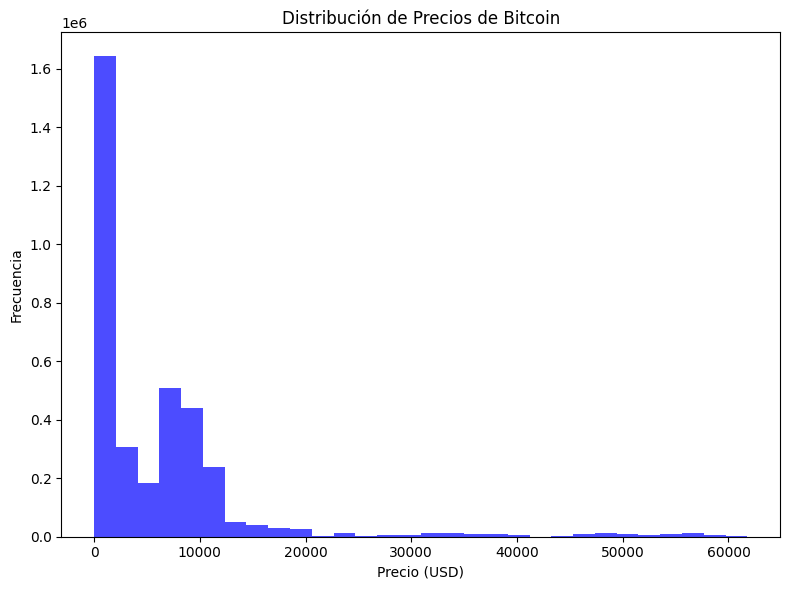

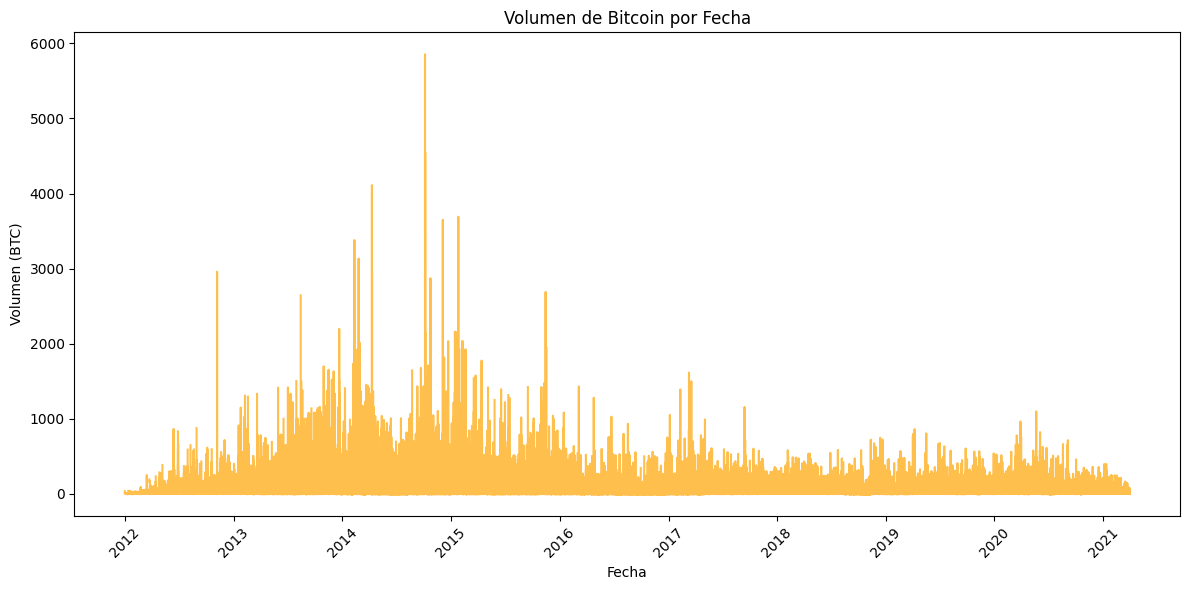

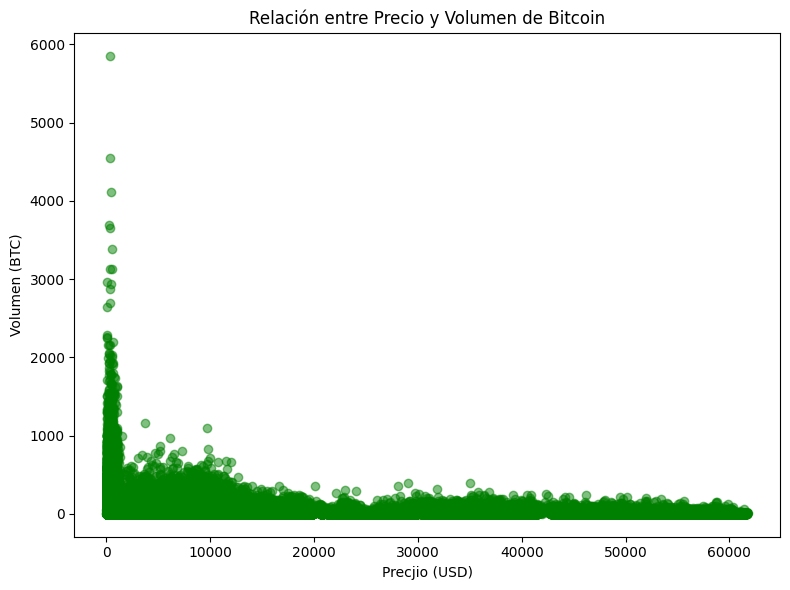

In [3]:
import matplotlib.pyplot as plt
df=pd.read_csv('/content/drive/MyDrive/Aprendizaje_automatico/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df['Timestamp'], unit='s'), df['Close'], label='Precio de Bitcoin', color='b')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.title('Precio de Bitcoin a lo largo del Tiempo')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['Close'], bins=30, color='b', alpha=0.7)
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios de Bitcoin')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df['Timestamp'], unit='s'), df['Volume_(BTC)'], color='orange', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Volumen (BTC)')
plt.title('Volumen de Bitcoin por Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['Close'], df['Volume_(BTC)'], color='green', alpha=0.5)
plt.xlabel('Precjio (USD)')
plt.ylabel('Volumen (BTC)')
plt.title('Relación entre Precio y Volumen de Bitcoin')
plt.tight_layout()
plt.show()

**PREPARACION DE LOS DATOS**

In [4]:
# Selecciona las columnas que deseas normalizar
features_to_normalize = df.drop(columns=['Timestamp'])

# Normaliza los datos seleccionados
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features_to_normalize)

# Crea un nuevo DataFrame con las características normalizadas
normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize.columns)

# Normaliza la columna de fecha
normalized_df['Timestamp'] = df['Timestamp']

print(normalized_df.head())

sequence_length = 1440  # Longitud de la secuencia
sequences = []
labels = []

# Crea las secuencias y las etiquetas
for i in range(2410000,int(len(normalized_df)/2) - sequence_length-1):
    sequence = normalized_df.iloc[i:i + sequence_length]  # Obtén la secuencia de longitud N
    columnas_numericas = sequence.select_dtypes(include=[np.number])
    sequence_filled = sequence.fillna(columnas_numericas.mean())

    sequence2 = normalized_df.iloc[i+1:i + sequence_length+1]# Obtén la siguiente secuencia de longitud N
    columnas_numericas2 = sequence2.select_dtypes(include=[np.number])
    sequence_filled2 = sequence2.fillna(columnas_numericas2.mean())
    # Obtén target de la siguiente secuencia de longitud N.
    # Si valor es nan nos quedamos con la media de la columna 'close' de la siguiente secuencia(que es la que incluye la serie cuyo 'close' es el target de la secuencia actual)
    if np.isnan( normalized_df.iloc[i + sequence_length]['Close']):
      target = sequence_filled2['Close'].mean()
    else:
      target = normalized_df.iloc[i + sequence_length]['Close']
    sequences.append(sequence_filled.values)  # Agrega la secuencia como un array de NumPy
    labels.append([target])

# Convierte las listas de secuencias y etiquetas en arrays de NumPy para usar en el modelo
sequences = np.array(sequences)
labels = np.array(labels)


      Open     High       Low     Close  Volume_(BTC)  Volume_(Currency)  \
0  0.00001  0.00001  0.000047  0.000047      0.000078       1.438779e-07   
1      NaN      NaN       NaN       NaN           NaN                NaN   
2      NaN      NaN       NaN       NaN           NaN                NaN   
3      NaN      NaN       NaN       NaN           NaN                NaN   
4      NaN      NaN       NaN       NaN           NaN                NaN   

   Weighted_Price   Timestamp  
0         0.00001  1325317920  
1             NaN  1325317980  
2             NaN  1325318040  
3             NaN  1325318100  
4             NaN  1325318160  


In [5]:
sequences.shape, labels.shape

((17247, 1440, 8), (17247, 1))

**RED LSTM**

Creamos modelo LSTM teniendo en cuenta la forma de los datos que en nuestro caso es (1400,8). Primero creamos LSTM con return_sequences=True para obtener todos los estados. Despues usamos otra LSTM pero con return_sequences=False para asi obtener solo el ultimo estado. Por último utilizamos capa densa de salida con sigmoide como funcion de activacion.

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Dropout
model = Sequential()
model.add(LSTM(32, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1440, 32)          5248      
                                                                 
 dropout (Dropout)           (None, 1440, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1440, 32)          8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21921 (85.63 KB)
Trainable params: 21921 (85.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compilamos ,entrenamos y evaluamos el modelo (utilizamos los 5000 primeras secuencias para entrenamiento, las siguientes 3000 para la validación y el resto para la evaluacion).\
Utilizamos adam como optimizador ya que el learning rate se va actualizando y mae como funcion de perdida ya que es la media de la diferencia absoluta entre cada predicción y su valor real(también habría sido posible utilizar el mse que es el sumatorio de la diferencias al cuadrado entre cada predicción y su valor real).

In [7]:
model.compile(optimizer='adam', loss='mae')

history = model.fit(sequences[:10000], labels[:10000], epochs=10, batch_size=100, validation_data=(sequences[10000:16000], labels[10000:16000]))

Epoch 1/10
100/100 [==============================] - 25s 153ms/step - loss: 0.0386 - val_loss: 1.8935e-04
Epoch 2/10
100/100 [==============================] - 14s 135ms/step - loss: 1.4863e-04 - val_loss: 1.4596e-04
Epoch 3/10
100/100 [==============================] - 13s 135ms/step - loss: 1.4018e-04 - val_loss: 1.4542e-04
Epoch 4/10
100/100 [==============================] - 14s 136ms/step - loss: 1.3301e-04 - val_loss: 1.5344e-04
Epoch 5/10
100/100 [==============================] - 13s 134ms/step - loss: 1.2651e-04 - val_loss: 1.7088e-04
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 1.2307e-04 - val_loss: 1.5476e-04
Epoch 7/10
100/100 [==============================] - 13s 135ms/step - loss: 1.1483e-04 - val_loss: 1.9416e-04
Epoch 8/10
100/100 [==============================] - 13s 135ms/step - loss: 1.1377e-04 - val_loss: 1.4731e-04
Epoch 9/10
100/100 [==============================] - 13s 134ms/step - loss: 1.1360e-04 - val_loss: 1.5720e-04
Epoch

In [8]:
model.evaluate(sequences[16000:], labels[16000:])

39/39 [==============================] - 3s 47ms/step - loss: 1.3208e-04


0.00013208057498559356

Visualizamos evolucion de train_loss y val_loss a lo largo de las epochs para ver si se produce overfitting

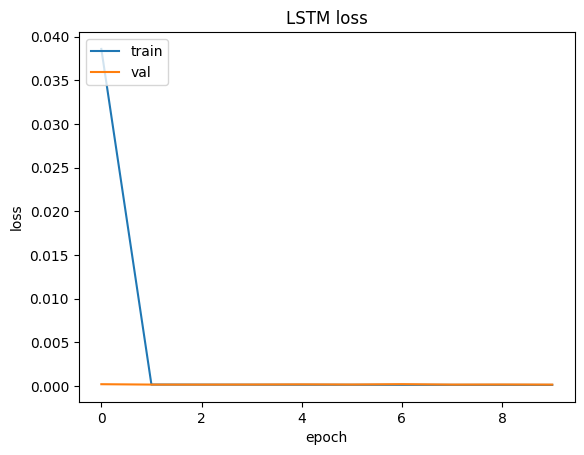

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**RED RNN**

Creamos modelo RNN teniendo en cuenta la forma de los datos que en nuestro caso es (1400,8). Primero creamos SimpleRNN con return_sequences=True para obtener todos los estados. Despues usamos otra SimpleRNN pero con return_sequences=False para asi obtener solo el ultimo estado. Por último utilizamos capa densa de salida con sigmoide como funcion de activacion.

In [12]:
model2 = Sequential()
model2.add(SimpleRNN(32, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1440, 32)          1312      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 1440, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5505 (21.50 KB)
Trainable params: 5505 (21.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compilamos, entrenamos y evaluamos el modelo (utilizamos los 5000 primeras secuencias para entrenamiento, las siguientes 3000 para la validación y el resto para la evaluacion).\
Utilizamos adam como optimizador ya que el learning rate se va actualizando y mae como funcion de perdida ya que es la media de la diferencia absoluta entre cada predicción y su valor real(también habría sido posible utilizar el mse que es el sumatorio de la diferencias al cuadrado entre cada predicción y su valor real).

In [13]:
model2.compile(optimizer='adam', loss='mae')

history = model2.fit(sequences[:10000], labels[:10000], epochs=10, batch_size=100, validation_data=(sequences[10000:16000], labels[10000:16000]))

Epoch 1/10
100/100 [==============================] - 311s 3s/step - loss: 0.0240 - val_loss: 1.5258e-04
Epoch 2/10
100/100 [==============================] - 294s 3s/step - loss: 1.0140e-04 - val_loss: 1.8955e-04
Epoch 3/10
100/100 [==============================] - 298s 3s/step - loss: 1.0098e-04 - val_loss: 1.6472e-04
Epoch 4/10
100/100 [==============================] - 295s 3s/step - loss: 1.0100e-04 - val_loss: 1.7000e-04
Epoch 5/10
100/100 [==============================] - 295s 3s/step - loss: 1.0152e-04 - val_loss: 1.9682e-04
Epoch 6/10
100/100 [==============================] - 297s 3s/step - loss: 1.0189e-04 - val_loss: 1.7120e-04
Epoch 7/10
100/100 [==============================] - 293s 3s/step - loss: 1.0221e-04 - val_loss: 1.6174e-04
Epoch 8/10
100/100 [==============================] - 297s 3s/step - loss: 1.0166e-04 - val_loss: 1.6329e-04
Epoch 9/10
100/100 [==============================] - 293s 3s/step - loss: 1.0249e-04 - val_loss: 1.8888e-04
Epoch 10/10
100/100 [==

In [14]:
model2.evaluate(sequences[16000:], labels[16000:])

39/39 [==============================] - 13s 322ms/step - loss: 2.3340e-04


0.00023340192274190485

Visualizamos evolucion de train_loss y val_loss a lo largo de las epochs para ver si se produce overfitting

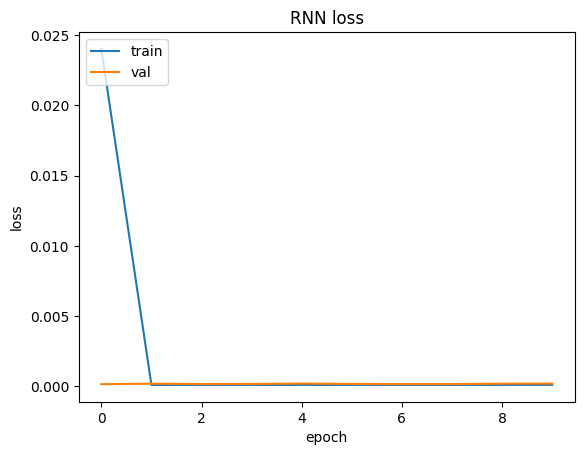

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Añadimos Dropout para evitar sobreajuste

In [22]:
model2 = Sequential()
model2.add(SimpleRNN(32, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_18 (SimpleRNN)   (None, 1440, 32)          1312      
                                                                 
 dropout_8 (Dropout)         (None, 1440, 32)          0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 1440, 32)          2080      
                                                                 
 simple_rnn_20 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5505 (21.50 KB)
Trainable params: 5505 (21.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model2.compile(optimizer='adam', loss='mae')

history = model2.fit(sequences[:10000], labels[:10000], epochs=10, batch_size=100, validation_data=(sequences[10000:16000], labels[10000:16000]))

Epoch 1/10
100/100 [==============================] - 303s 3s/step - loss: 0.0458 - val_loss: 4.2465e-04
Epoch 2/10
100/100 [==============================] - 296s 3s/step - loss: 6.5320e-04 - val_loss: 3.5288e-04
Epoch 3/10
100/100 [==============================] - 294s 3s/step - loss: 4.3033e-04 - val_loss: 2.8365e-04
Epoch 4/10
100/100 [==============================] - 296s 3s/step - loss: 3.1971e-04 - val_loss: 1.8736e-04
Epoch 5/10
100/100 [==============================] - 296s 3s/step - loss: 2.4685e-04 - val_loss: 1.5036e-04
Epoch 6/10
100/100 [==============================] - 294s 3s/step - loss: 2.0614e-04 - val_loss: 1.4807e-04
Epoch 7/10
100/100 [==============================] - 295s 3s/step - loss: 1.7737e-04 - val_loss: 1.4435e-04
Epoch 8/10
100/100 [==============================] - 293s 3s/step - loss: 1.6262e-04 - val_loss: 1.4279e-04
Epoch 9/10
100/100 [==============================] - 295s 3s/step - loss: 1.4885e-04 - val_loss: 1.4287e-04
Epoch 10/10
100/100 [==

In [24]:
model2.evaluate(sequences[16000:], labels[16000:])

39/39 [==============================] - 13s 320ms/step - loss: 1.0035e-04


0.0001003504148684442

**RED GRU**

In [27]:
from keras.layers import GRU

model3 = Sequential()
model3.add(GRU(32, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model3.add(Dropout(0.2))
model3.add(GRU(32, return_sequences=True))
model3.add(GRU(32))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 1440, 32)          4032      
                                                                 
 dropout_10 (Dropout)        (None, 1440, 32)          0         
                                                                 
 gru_4 (GRU)                 (None, 1440, 32)          6336      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16737 (65.38 KB)
Trainable params: 16737 (65.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model3.compile(optimizer='adam', loss='mae')

history = model3.fit(sequences[:10000], labels[:10000], epochs=10, batch_size=100, validation_data=(sequences[10000:16000], labels[10000:16000]))

Epoch 1/10
100/100 [==============================] - 20s 155ms/step - loss: 0.0348 - val_loss: 2.8281e-04
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 3.1378e-04 - val_loss: 3.2366e-04
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 2.0330e-04 - val_loss: 2.1489e-04
Epoch 4/10
100/100 [==============================] - 13s 132ms/step - loss: 1.5695e-04 - val_loss: 2.2135e-04
Epoch 5/10
100/100 [==============================] - 13s 130ms/step - loss: 1.3386e-04 - val_loss: 1.6726e-04
Epoch 6/10
100/100 [==============================] - 15s 155ms/step - loss: 1.2223e-04 - val_loss: 1.5496e-04
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss: 1.1645e-04 - val_loss: 1.4513e-04
Epoch 8/10
100/100 [==============================] - 13s 131ms/step - loss: 1.1464e-04 - val_loss: 1.4653e-04
Epoch 9/10
100/100 [==============================] - 13s 131ms/step - loss: 1.1184e-04 - val_loss: 1.4471e-04
Epoch

In [29]:
model3.evaluate(sequences[16000:], labels[16000:])

39/39 [==============================] - 4s 58ms/step - loss: 4.4406e-05


4.440554403117858e-05

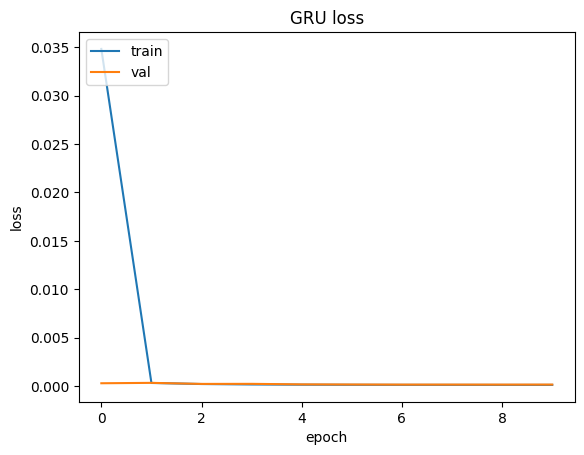

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GRU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**CONCLUSIONES**


Como podemos obserbar el modelo que mejor esta funcionando es el GRU, después el RNN y por ultimo el LSTM (otras veces que he ejecutado el codigo el LSTM ha sido el que ha dado un mejor resultado). Sin embargo el unico suficientemente bueno como para hacer una predicion en condiciones del precio de cierre de btc es el GRU y esta predicion no llega a ser buena del todo(a mi gusto faltan variables dependientes para hacer una buena prediccion).\
También con las primeras graficas nos damos cuenta de que el rango de precio en el que mas tiempo ha estado btc es entre 0 y 2000(a partir de ahi el resto de rangos bajan drásticamente en frecuencia de datos), por tanto la mayoria de las series temporales cierran en ese rango. Yo creo que convendría coger menos datos del inicio para igualar la cantidad de datos en todos los rangos de tiempo, por ello a la hora de preparar los datos y crear las secuencias y etiquetas he empezado a partir de un numero hasta la longitud del df entero(no obstante como eran muchos datos no he podido coger el rango que me habria gustado).

